In [ ]:
import os
import sys
os.chdir('..')

if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

In [3]:
dataset = pd.read_csv('data/cleaned_tripadvisor_reviews.csv', index_col=0)
labels = dataset['Rating'].values - 1


In [ ]:
dataset.head()

,Review,Rating,cleaned_text
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking get good deal sta...
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,nice room 4 experience hotel monaco seattle go...
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay go seahawk game awesome ...


# ***Baseline Model***

In [6]:
# Define hyperparameters
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 64

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(dataset['cleaned_text'])
sequences = tokenizer.texts_to_sequences(dataset['cleaned_text'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, truncating='post', padding='post')


In [ ]:
model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(5, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           640000    
                                                                 
 lstm (LSTM)                 (None, 100, 64)           33024     
                                                                 
 dropout (Dropout)           (None, 100, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
Total params: 685605 (2.62 MB)
Trainable params: 685605 (2.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
train_sequences, val_sequences, train_labels, val_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

history = model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=5, batch_size=32)


Epoch 1/5
513/513 [==============================] - 76s 138ms/step - loss: 1.2750 - accuracy: 0.4480 - val_loss: 1.3107 - val_accuracy: 0.4389
Epoch 2/5
513/513 [==============================] - 67s 130ms/step - loss: 1.1510 - accuracy: 0.4844 - val_loss: 1.0754 - val_accuracy: 0.5052
Epoch 3/5
513/513 [==============================] - 68s 133ms/step - loss: 1.0285 - accuracy: 0.5362 - val_loss: 1.0497 - val_accuracy: 0.5284
Epoch 4/5
513/513 [==============================] - 67s 131ms/step - loss: 1.0302 - accuracy: 0.5368 - val_loss: 1.0323 - val_accuracy: 0.5321
Epoch 5/5
513/513 [==============================] - 70s 136ms/step - loss: 0.9566 - accuracy: 0.5743 - val_loss: 1.1463 - val_accuracy: 0.4879


In [ ]:
# model evaluation
val_loss, val_accuracy = model.evaluate(val_sequences, val_labels)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# get prédictions
predictions = model.predict(val_sequences)
predicted_labels = [np.argmax(prediction) for prediction in predictions]

# classification report
print(classification_report(val_labels, predicted_labels))


129/129 [==============================] - 4s 28ms/step - loss: 1.1463 - accuracy: 0.4879
Validation Loss: 1.1463364362716675
Validation Accuracy: 0.48792389035224915
129/129 [==============================] - 5s 28ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       292
           1       0.25      0.01      0.01       333
           2       0.23      0.38      0.28       432
           3       0.35      0.16      0.22      1252
           4       0.59      0.91      0.72      1790

    accuracy                           0.49      4099
   macro avg       0.28      0.29      0.25      4099
weighted avg       0.41      0.49      0.41      4099



### ***observation:***

the model is absolutely unable to detect 0 and 1. For a first model it is not really convincing but it is just the beginning

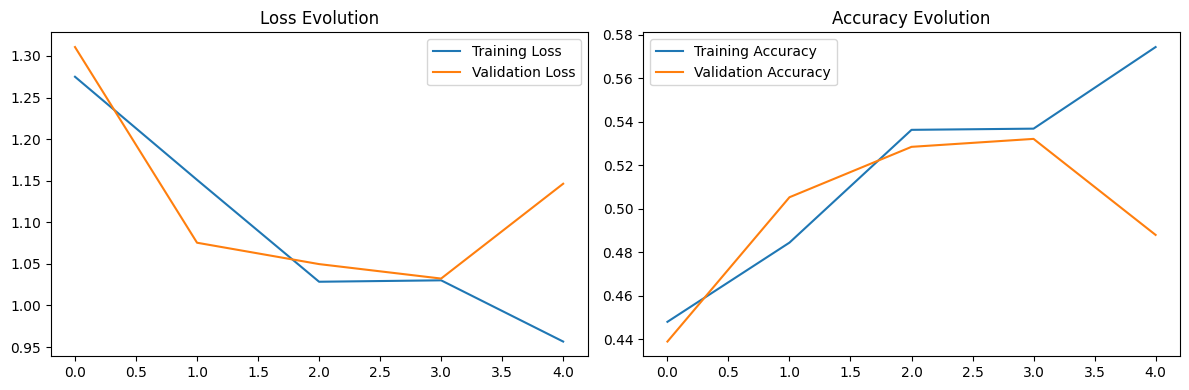

In [ ]:
# Plotting loss curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.tight_layout()
plt.show()

### ***observation:***

Not so bad. If we do not consider the last point that looks like an error. the curves are close to each other and have the same trend. By looking at this curves the first thing that comes to my mind is that we can train the model with more epochs as the results are globally improving.

# ***Add more epoch and implementing a checkpoint to remember the best epoch, also implementing early stopping and LR to avoid overfitting***

In [ ]:
train_sequences, val_sequences, train_labels, val_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
checkpoint = ModelCheckpoint('model1.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_cb = ReduceLROnPlateau(monitor="loss", patience=10)

history = model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=20, batch_size=32, callbacks=[checkpoint, early_stopping_cb, lr_cb])


Epoch 1/20
513/513 [==============================] - ETA: 0s - loss: 0.9334 - accuracy: 0.5845
Epoch 1: val_loss improved from inf to 0.97578, saving model to model1.h5
513/513 [==============================] - 73s 142ms/step - loss: 0.9334 - accuracy: 0.5845 - val_loss: 0.9758 - val_accuracy: 0.5726 - lr: 0.0010
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


513/513 [==============================] - ETA: 0s - loss: 0.8397 - accuracy: 0.6356
Epoch 2: val_loss improved from 0.97578 to 0.95334, saving model to model1.h5
513/513 [==============================] - 68s 132ms/step - loss: 0.8397 - accuracy: 0.6356 - val_loss: 0.9533 - val_accuracy: 0.5687 - lr: 0.0010
Epoch 3/20
513/513 [==============================] - ETA: 0s - loss: 0.7652 - accuracy: 0.6740
Epoch 3: val_loss improved from 0.95334 to 0.95263, saving model to model1.h5
513/513 [==============================] - 68s 133ms/step - loss: 0.7652 - accuracy: 0.6740 - val_loss: 0.9526 - val_accuracy: 0.5884 - lr: 0.0010
Epoch 4/20
513/513 [==============================] - ETA: 0s - loss: 0.6774 - accuracy: 0.7246
Epoch 4: val_loss did not improve from 0.95263
513/513 [==============================] - 66s 128ms/step - loss: 0.6774 - accuracy: 0.7246 - val_loss: 0.9649 - val_accuracy: 0.5965 - lr: 0.0010
Epoch 5/20
513/513 [==============================] - ETA: 0s - loss: 0.6144 - 

In [ ]:
# model evaluation
val_loss, val_accuracy = model.evaluate(val_sequences, val_labels)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# get prédictions
predictions = model.predict(val_sequences)
predicted_labels = [np.argmax(prediction) for prediction in predictions]

# classification report
print(classification_report(val_labels, predicted_labels))


129/129 [==============================] - 5s 36ms/step - loss: 0.9526 - accuracy: 0.5884
Validation Loss: 0.9526312947273254
Validation Accuracy: 0.5884361863136292
129/129 [==============================] - 4s 28ms/step
              precision    recall  f1-score   support

           0       0.64      0.53      0.58       292
           1       0.35      0.42      0.39       333
           2       0.35      0.21      0.26       432
           3       0.50      0.41      0.45      1252
           4       0.70      0.85      0.76      1790

    accuracy                           0.59      4099
   macro avg       0.51      0.48      0.49      4099
weighted avg       0.57      0.59      0.57      4099



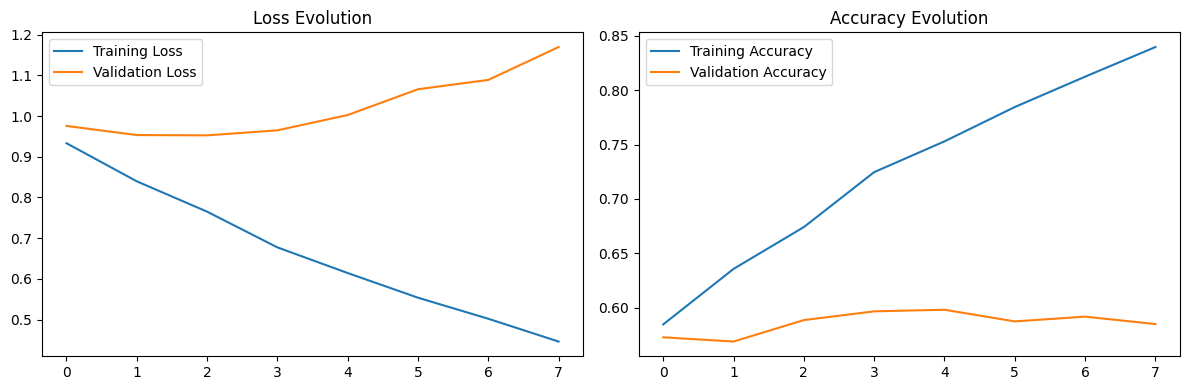

In [ ]:
# Plotting loss curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.tight_layout()
plt.show()


### ***observation:***

This model is a huge improvement comparated to the previous one. We are close to the result with ML and we are still facing the same problems with the class 2 and 3. By looking at the curves we recognize overfitting that is still important there.

# ***Implementing class weights***

as we know that our dataset is imbalanced, we will try to implement class weights to see if we can improve our model.

In [ ]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

In [ ]:
history = model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=7, batch_size=32, class_weight=class_weights_dict, callbacks=[checkpoint, early_stopping_cb, lr_cb])

Epoch 1/7
513/513 [==============================] - ETA: 0s - loss: 0.8153 - accuracy: 0.6988
Epoch 1: val_loss did not improve from 0.95263
513/513 [==============================] - 72s 133ms/step - loss: 0.8153 - accuracy: 0.6988 - val_loss: 0.9722 - val_accuracy: 0.5962 - lr: 0.0010
Epoch 2/7
513/513 [==============================] - ETA: 0s - loss: 0.7291 - accuracy: 0.7207
Epoch 2: val_loss did not improve from 0.95263
513/513 [==============================] - 67s 131ms/step - loss: 0.7291 - accuracy: 0.7207 - val_loss: 1.1278 - val_accuracy: 0.5548 - lr: 0.0010
Epoch 3/7
513/513 [==============================] - ETA: 0s - loss: 0.6492 - accuracy: 0.7472
Epoch 3: val_loss did not improve from 0.95263
513/513 [==============================] - 69s 134ms/step - loss: 0.6492 - accuracy: 0.7472 - val_loss: 1.1032 - val_accuracy: 0.5653 - lr: 0.0010
Epoch 4/7
513/513 [==============================] - ETA: 0s - loss: 0.5733 - accuracy: 0.7737
Epoch 4: val_loss did not improve from

In [ ]:
# model evaluation
val_loss, val_accuracy = model.evaluate(val_sequences, val_labels)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# get prédictions
predictions = model.predict(val_sequences)
predicted_labels = [np.argmax(prediction) for prediction in predictions]

# classification report
print(classification_report(val_labels, predicted_labels))


129/129 [==============================] - 4s 29ms/step - loss: 0.9722 - accuracy: 0.5962
Validation Loss: 0.972150444984436
Validation Accuracy: 0.5962429642677307
129/129 [==============================] - 4s 33ms/step
              precision    recall  f1-score   support

           0       0.70      0.53      0.61       292
           1       0.38      0.49      0.43       333
           2       0.36      0.27      0.31       432
           3       0.50      0.55      0.53      1252
           4       0.76      0.74      0.75      1790

    accuracy                           0.60      4099
   macro avg       0.54      0.52      0.52      4099
weighted avg       0.60      0.60      0.60      4099



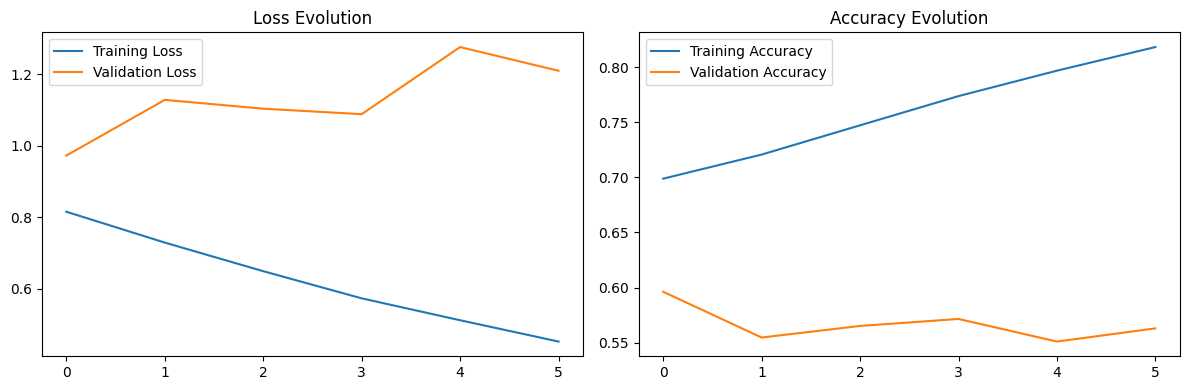

In [ ]:
# Plotting loss curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.tight_layout()
plt.show()

### ***observation:***

Result are worst than previous one, the model is still overfitting.

# ***Reducing the complexity of the model to reduce overfitting***

first, I want to try without the class weight to see the difference even if overfitting was not as big on the first model without class weight. Then we will try to work on class weight with this simpler model.

In [ ]:
model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(64),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 200, 64)           640000    
                                                                 
 lstm_8 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 5)                 325       
                                                                 
Total params: 673349 (2.57 MB)
Trainable params: 673349 (2.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
train_sequences, val_sequences, train_labels, val_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

history = model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=20, batch_size=32, callbacks=[checkpoint, early_stopping_cb, lr_cb])

Epoch 1/20
513/513 [==============================] - ETA: 0s - loss: 1.3690 - accuracy: 0.4407
Epoch 1: val_loss did not improve from 0.84617
513/513 [==============================] - 81s 153ms/step - loss: 1.3690 - accuracy: 0.4407 - val_loss: 1.3475 - val_accuracy: 0.4382 - lr: 0.0010
Epoch 2/20
513/513 [==============================] - ETA: 0s - loss: 1.3461 - accuracy: 0.4505
Epoch 2: val_loss did not improve from 0.84617
513/513 [==============================] - 78s 152ms/step - loss: 1.3461 - accuracy: 0.4505 - val_loss: 1.3282 - val_accuracy: 0.4462 - lr: 0.0010
Epoch 3/20
513/513 [==============================] - ETA: 0s - loss: 1.2815 - accuracy: 0.4766
Epoch 3: val_loss did not improve from 0.84617
513/513 [==============================] - 80s 155ms/step - loss: 1.2815 - accuracy: 0.4766 - val_loss: 1.2861 - val_accuracy: 0.4635 - lr: 0.0010
Epoch 4/20
513/513 [==============================] - ETA: 0s - loss: 1.3002 - accuracy: 0.4562
Epoch 4: val_loss did not improve 

### ***observation:***

Needless to say that it did not worked.

# ***Implementing class weights on the simpler model***

In [ ]:
model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(64),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 64)           640000    
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 673349 (2.57 MB)
Trainable params: 673349 (2.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
train_sequences, val_sequences, train_labels, val_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
history = model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=7, batch_size=32, class_weight=class_weights_dict, callbacks=[checkpoint, early_stopping_cb, lr_cb])

Epoch 1/7
513/513 [==============================] - ETA: 0s - loss: 1.5178 - accuracy: 0.3283
Epoch 1: val_loss did not improve from 0.95263
513/513 [==============================] - 45s 83ms/step - loss: 1.5178 - accuracy: 0.3283 - val_loss: 1.3067 - val_accuracy: 0.4852 - lr: 0.0010
Epoch 2/7
513/513 [==============================] - ETA: 0s - loss: 1.3848 - accuracy: 0.4270
Epoch 2: val_loss did not improve from 0.95263
513/513 [==============================] - 41s 80ms/step - loss: 1.3848 - accuracy: 0.4270 - val_loss: 1.3318 - val_accuracy: 0.4877 - lr: 0.0010
Epoch 3/7
513/513 [==============================] - ETA: 0s - loss: 1.2671 - accuracy: 0.4808
Epoch 3: val_loss did not improve from 0.95263
513/513 [==============================] - 44s 85ms/step - loss: 1.2671 - accuracy: 0.4808 - val_loss: 1.2259 - val_accuracy: 0.4872 - lr: 0.0010
Epoch 4/7
513/513 [==============================] - ETA: 0s - loss: 1.1507 - accuracy: 0.4944
Epoch 4: val_loss did not improve from 0.

### ***observation:***

This simple model is not a good idea. we will not go further as we has facing a huge overfitting on 2 different test.

# ***Changing the embedding dimension***

In [ ]:
# Define hyperparameters
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 200
EMBEDDING_DIM = 64

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(dataset['cleaned_text'])
sequences = tokenizer.texts_to_sequences(dataset['cleaned_text'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, truncating='post', padding='post')

In [ ]:
model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(5, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 64)           640000    
                                                                 
 lstm_4 (LSTM)               (None, 200, 64)           33024     
                                                                 
 dropout_3 (Dropout)         (None, 200, 64)           0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_3 (Dense)             (None, 5)                 165       
                                                                 
Total params: 685605 (2.62 MB)
Trainable params: 685605 (2.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
train_sequences, val_sequences, train_labels, val_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
history = model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=5, batch_size=32)

Epoch 1/5
513/513 [==============================] - 141s 265ms/step - loss: 1.3608 - accuracy: 0.4426 - val_loss: 1.3457 - val_accuracy: 0.4408
Epoch 2/5
513/513 [==============================] - 133s 260ms/step - loss: 1.3372 - accuracy: 0.4510 - val_loss: 1.3440 - val_accuracy: 0.4386
Epoch 3/5
513/513 [==============================] - 133s 258ms/step - loss: 1.3260 - accuracy: 0.4588 - val_loss: 1.3614 - val_accuracy: 0.4362
Epoch 4/5
513/513 [==============================] - 137s 266ms/step - loss: 1.3293 - accuracy: 0.4578 - val_loss: 1.3447 - val_accuracy: 0.4391
Epoch 5/5
513/513 [==============================] - 138s 269ms/step - loss: 1.3040 - accuracy: 0.4715 - val_loss: 1.3712 - val_accuracy: 0.4340


### ***observation:***

No need to go further, the model seems to be unable to learn more.

# ***trying to change batch size***

In [ ]:
model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(64),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()


In [ ]:
history = model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=20, batch_size=64)


Epoch 1/20
257/257 [==============================] - 52s 194ms/step - loss: 1.3730 - accuracy: 0.4405 - val_loss: 1.3509 - val_accuracy: 0.4367
Epoch 2/20
257/257 [==============================] - 49s 190ms/step - loss: 1.3358 - accuracy: 0.4433 - val_loss: 1.2917 - val_accuracy: 0.4362
Epoch 3/20
257/257 [==============================] - 47s 183ms/step - loss: 1.3584 - accuracy: 0.4462 - val_loss: 1.3484 - val_accuracy: 0.4362
Epoch 4/20
257/257 [==============================] - 47s 183ms/step - loss: 1.3511 - accuracy: 0.4554 - val_loss: 1.3533 - val_accuracy: 0.4369
Epoch 5/20
257/257 [==============================] - 47s 183ms/step - loss: 1.3428 - accuracy: 0.4563 - val_loss: 1.3333 - val_accuracy: 0.4457
Epoch 6/20
257/257 [==============================] - 50s 196ms/step - loss: 1.2988 - accuracy: 0.4675 - val_loss: 1.2445 - val_accuracy: 0.4416
Epoch 7/20
257/257 [==============================] - 50s 193ms/step - loss: 1.2411 - accuracy: 0.4748 - val_loss: 1.2634 - val_ac

### ***observation:***

the results are not as good as the others models so we will keep 32 as batch size.

# ***trying to change the model layers***

In [ ]:
model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(5, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 200, 64)           640000    
                                                                 
 conv1d (Conv1D)             (None, 196, 128)          41088     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_5 (Dense)             (None, 5)                 645       
                                                                 
Total params: 681733 (2.60 MB)
Trainable params: 681733 (2.60 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
train_sequences, val_sequences, train_labels, val_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

history = model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=15, batch_size=32, callbacks=[checkpoint, early_stopping_cb, lr_cb])

Epoch 1/15
512/513 [============================>.] - ETA: 0s - loss: 1.1194 - accuracy: 0.5189
Epoch 1: val_loss improved from 0.95263 to 0.91311, saving model to model1.h5
513/513 [==============================] - 34s 64ms/step - loss: 1.1194 - accuracy: 0.5189 - val_loss: 0.9131 - val_accuracy: 0.5955 - lr: 0.0010
Epoch 2/15
  2/513 [..............................] - ETA: 28s - loss: 0.8602 - accuracy: 0.6094

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


512/513 [============================>.] - ETA: 0s - loss: 0.8156 - accuracy: 0.6528
Epoch 2: val_loss improved from 0.91311 to 0.87135, saving model to model1.h5
513/513 [==============================] - 32s 63ms/step - loss: 0.8160 - accuracy: 0.6528 - val_loss: 0.8714 - val_accuracy: 0.6238 - lr: 0.0010
Epoch 3/15
512/513 [============================>.] - ETA: 0s - loss: 0.6250 - accuracy: 0.7546
Epoch 3: val_loss did not improve from 0.87135
513/513 [==============================] - 31s 60ms/step - loss: 0.6250 - accuracy: 0.7545 - val_loss: 0.9067 - val_accuracy: 0.6119 - lr: 0.0010
Epoch 4/15
512/513 [============================>.] - ETA: 0s - loss: 0.4220 - accuracy: 0.8608
Epoch 4: val_loss did not improve from 0.87135
513/513 [==============================] - 32s 63ms/step - loss: 0.4221 - accuracy: 0.8608 - val_loss: 1.0045 - val_accuracy: 0.6060 - lr: 0.0010
Epoch 5/15
512/513 [============================>.] - ETA: 0s - loss: 0.2327 - accuracy: 0.9453
Epoch 5: val_loss

In [ ]:
# model evaluation
val_loss, val_accuracy = model.evaluate(val_sequences, val_labels)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# get prédictions
predictions = model.predict(val_sequences)
predicted_labels = [np.argmax(prediction) for prediction in predictions]

# classification report
print(classification_report(val_labels, predicted_labels))

129/129 [==============================] - 2s 14ms/step - loss: 0.8714 - accuracy: 0.6238
Validation Loss: 0.8713528513908386
Validation Accuracy: 0.6238107085227966
129/129 [==============================] - 2s 13ms/step
              precision    recall  f1-score   support

           0       0.72      0.48      0.57       292
           1       0.38      0.40      0.39       333
           2       0.47      0.25      0.32       432
           3       0.54      0.54      0.54      1252
           4       0.73      0.84      0.78      1790

    accuracy                           0.62      4099
   macro avg       0.57      0.50      0.52      4099
weighted avg       0.61      0.62      0.61      4099



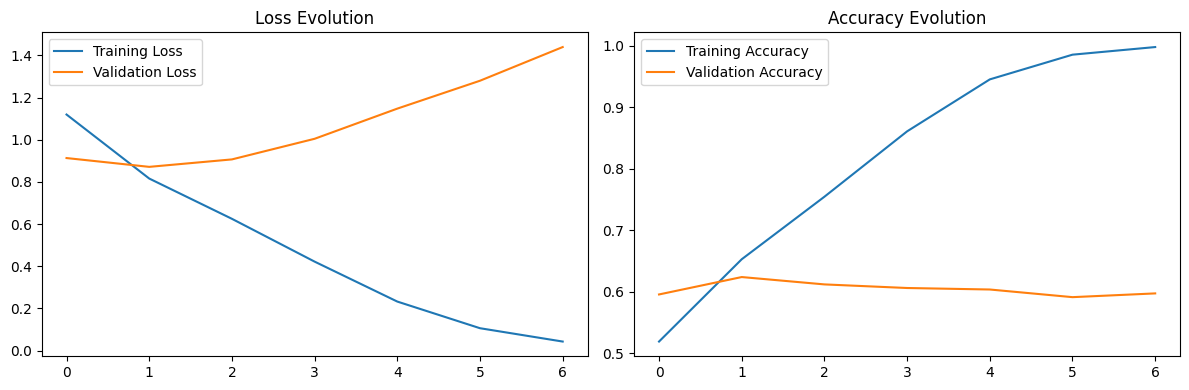

In [ ]:
# Plotting loss and accuracy curves using the best model
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.tight_layout()
plt.show()

### ***observation:***

We finally found something that improved our result! the model is still in overfitting (huge overfitting) but accuracy increased and the recall for class 2 and 3 is average knowing the difficulties that we face. we will investigate others models

# ***Another different model***

In [ ]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.regularizers import l2

model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Conv1D(128, 5, activation='relu', kernel_regularizer=l2(0.01)),  # Couche de convolution avec régularisation L2
    GlobalMaxPooling1D(),  # Pooling global
    Dense(5, activation='softmax', kernel_regularizer=l2(0.01))  # Couche Dense avec régularisation L2
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 200, 64)           640000    
                                                                 
 conv1d_1 (Conv1D)           (None, 196, 128)          41088     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_6 (Dense)             (None, 5)                 645       
                                                                 
Total params: 681733 (2.60 MB)
Trainable params: 681733 (2.60 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
train_sequences, val_sequences, train_labels, val_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

history = model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=15, batch_size=32, callbacks=[checkpoint, early_stopping_cb, lr_cb])

Epoch 1/15
512/513 [============================>.] - ETA: 0s - loss: 1.4069 - accuracy: 0.4414
Epoch 1: val_loss did not improve from 0.87135
513/513 [==============================] - 30s 58ms/step - loss: 1.4070 - accuracy: 0.4413 - val_loss: 1.2589 - val_accuracy: 0.4704 - lr: 0.0010
Epoch 2/15
513/513 [==============================] - ETA: 0s - loss: 1.2112 - accuracy: 0.5030
Epoch 2: val_loss did not improve from 0.87135
513/513 [==============================] - 30s 58ms/step - loss: 1.2112 - accuracy: 0.5030 - val_loss: 1.1574 - val_accuracy: 0.5479 - lr: 0.0010
Epoch 3/15
512/513 [============================>.] - ETA: 0s - loss: 1.1199 - accuracy: 0.5583
Epoch 3: val_loss did not improve from 0.87135
513/513 [==============================] - 30s 59ms/step - loss: 1.1198 - accuracy: 0.5583 - val_loss: 1.1140 - val_accuracy: 0.5711 - lr: 0.0010
Epoch 4/15
512/513 [============================>.] - ETA: 0s - loss: 1.0640 - accuracy: 0.5944
Epoch 4: val_loss did not improve fro

In [ ]:
# model evaluation
val_loss, val_accuracy = model.evaluate(val_sequences, val_labels)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# get prédictions
predictions = model.predict(val_sequences)
predicted_labels = [np.argmax(prediction) for prediction in predictions]

# classification report
print(classification_report(val_labels, predicted_labels))

129/129 [==============================] - 2s 14ms/step - loss: 1.0924 - accuracy: 0.5811
Validation Loss: 1.0923666954040527
Validation Accuracy: 0.5811173319816589
129/129 [==============================] - 2s 14ms/step
              precision    recall  f1-score   support

           0       0.61      0.51      0.55       292
           1       0.38      0.21      0.27       333
           2       0.33      0.07      0.11       432
           3       0.46      0.48      0.47      1252
           4       0.67      0.86      0.75      1790

    accuracy                           0.58      4099
   macro avg       0.49      0.42      0.43      4099
weighted avg       0.54      0.58      0.55      4099



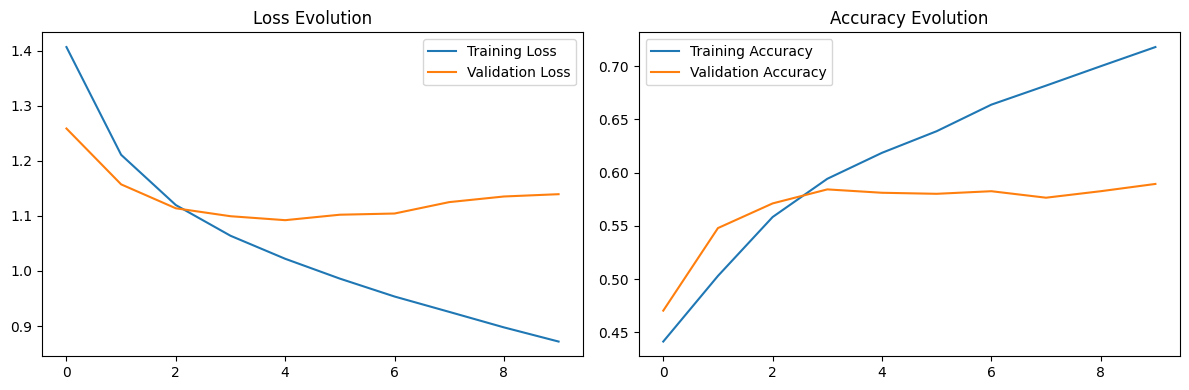

In [ ]:
# Plotting loss and accuracy curves using the best model
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.tight_layout()
plt.show()

### ***observation:***

This model is more robust to overitting. Curves are pretier but the result are worst than previous one. model in unable to detect class 3

# ***Another different model***

In [ ]:
model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Bidirectional(LSTM(64)),  # Bi-LSTM
    Dropout(0.2),
    Dense(5, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 200, 64)           640000    
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 5)                 645       
                                                                 
Total params: 706693 (2.70 MB)
Trainable params: 706693 (2.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
train_sequences, val_sequences, train_labels, val_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

history = model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=7, batch_size=32, callbacks=[checkpoint, early_stopping_cb, lr_cb])


Epoch 1/7
513/513 [==============================] - ETA: 0s - loss: 1.0094 - accuracy: 0.5628
Epoch 1: val_loss did not improve from 0.87135
513/513 [==============================] - 142s 265ms/step - loss: 1.0094 - accuracy: 0.5628 - val_loss: 0.8849 - val_accuracy: 0.6153 - lr: 0.0010
Epoch 2/7
513/513 [==============================] - ETA: 0s - loss: 0.7700 - accuracy: 0.6623
Epoch 2: val_loss improved from 0.87135 to 0.84617, saving model to model1.h5
513/513 [==============================] - 133s 259ms/step - loss: 0.7700 - accuracy: 0.6623 - val_loss: 0.8462 - val_accuracy: 0.6233 - lr: 0.0010
Epoch 3/7


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


513/513 [==============================] - ETA: 0s - loss: 0.6715 - accuracy: 0.7151
Epoch 3: val_loss did not improve from 0.84617
513/513 [==============================] - 133s 259ms/step - loss: 0.6715 - accuracy: 0.7151 - val_loss: 0.9014 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/7
513/513 [==============================] - ETA: 0s - loss: 0.5890 - accuracy: 0.7595
Epoch 4: val_loss did not improve from 0.84617
513/513 [==============================] - 133s 260ms/step - loss: 0.5890 - accuracy: 0.7595 - val_loss: 0.9179 - val_accuracy: 0.6289 - lr: 0.0010
Epoch 5/7
513/513 [==============================] - ETA: 0s - loss: 0.5460 - accuracy: 0.7826
Epoch 5: val_loss did not improve from 0.84617
513/513 [==============================] - 130s 254ms/step - loss: 0.5460 - accuracy: 0.7826 - val_loss: 1.0145 - val_accuracy: 0.5923 - lr: 0.0010
Epoch 6/7
513/513 [==============================] - ETA: 0s - loss: 0.4586 - accuracy: 0.8250
Epoch 6: val_loss did not improve from 0.8461

In [ ]:
# model evaluation
val_loss, val_accuracy = model.evaluate(val_sequences, val_labels)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# get prédictions
predictions = model.predict(val_sequences)
predicted_labels = [np.argmax(prediction) for prediction in predictions]

# classification report
print(classification_report(val_labels, predicted_labels))

129/129 [==============================] - 8s 58ms/step - loss: 0.8462 - accuracy: 0.6233
Validation Loss: 0.8461746573448181
Validation Accuracy: 0.6233227849006653
129/129 [==============================] - 10s 67ms/step
              precision    recall  f1-score   support

           0       0.68      0.58      0.62       292
           1       0.40      0.50      0.45       333
           2       0.44      0.34      0.38       432
           3       0.54      0.62      0.58      1252
           4       0.79      0.72      0.75      1790

    accuracy                           0.62      4099
   macro avg       0.57      0.55      0.56      4099
weighted avg       0.63      0.62      0.63      4099



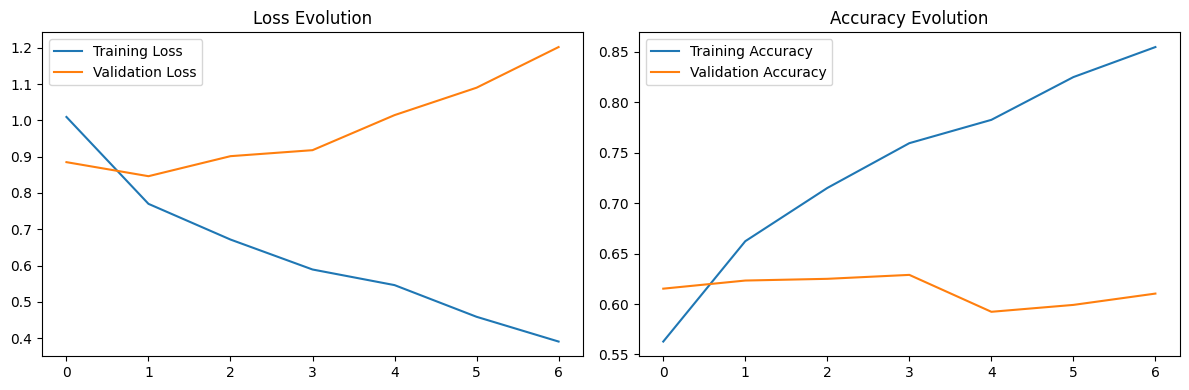

In [ ]:
# Plotting loss and accuracy curves using the best model
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.tight_layout()
plt.show()

No doubt that this model is the best one when we compare the f1 score for each class. The From now we will stop our investigation and just focus more on this model and try to reduce overfitting to improve the model

# ***Class weight on the best model***

In [ ]:
model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Bidirectional(LSTM(64)),  # Bi-LSTM
    Dropout(0.2),
    Dense(5, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 200, 64)           640000    
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 5)                 645       
                                                                 
Total params: 706693 (2.70 MB)
Trainable params: 706693 (2.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
train_sequences, val_sequences, train_labels, val_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

history = model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=7, batch_size=32,class_weight=class_weights_dict, callbacks=[checkpoint, early_stopping_cb, lr_cb])


Epoch 1/7
513/513 [==============================] - ETA: 0s - loss: 1.1837 - accuracy: 0.4974
Epoch 1: val_loss did not improve from 0.84617
513/513 [==============================] - 160s 300ms/step - loss: 1.1837 - accuracy: 0.4974 - val_loss: 0.9234 - val_accuracy: 0.5958 - lr: 0.0010
Epoch 2/7
513/513 [==============================] - ETA: 0s - loss: 0.8660 - accuracy: 0.6295
Epoch 2: val_loss did not improve from 0.84617
513/513 [==============================] - 134s 262ms/step - loss: 0.8660 - accuracy: 0.6295 - val_loss: 0.8900 - val_accuracy: 0.5992 - lr: 0.0010
Epoch 3/7
513/513 [==============================] - ETA: 0s - loss: 0.7218 - accuracy: 0.6884
Epoch 3: val_loss did not improve from 0.84617
513/513 [==============================] - 162s 315ms/step - loss: 0.7218 - accuracy: 0.6884 - val_loss: 1.0396 - val_accuracy: 0.5392 - lr: 0.0010
Epoch 4/7
513/513 [==============================] - ETA: 0s - loss: 0.6014 - accuracy: 0.7261
Epoch 4: val_loss did not improve f

In [ ]:
# model evaluation
val_loss, val_accuracy = model.evaluate(val_sequences, val_labels)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# get prédictions
predictions = model.predict(val_sequences)
predicted_labels = [np.argmax(prediction) for prediction in predictions]

# classification report
print(classification_report(val_labels, predicted_labels))

129/129 [==============================] - 11s 85ms/step - loss: 0.8900 - accuracy: 0.5992
Validation Loss: 0.8899964094161987
Validation Accuracy: 0.5991705060005188
129/129 [==============================] - 14s 96ms/step
              precision    recall  f1-score   support

           0       0.71      0.64      0.67       292
           1       0.40      0.55      0.46       333
           2       0.32      0.44      0.37       432
           3       0.53      0.48      0.50      1252
           4       0.78      0.73      0.75      1790

    accuracy                           0.60      4099
   macro avg       0.55      0.57      0.55      4099
weighted avg       0.62      0.60      0.61      4099



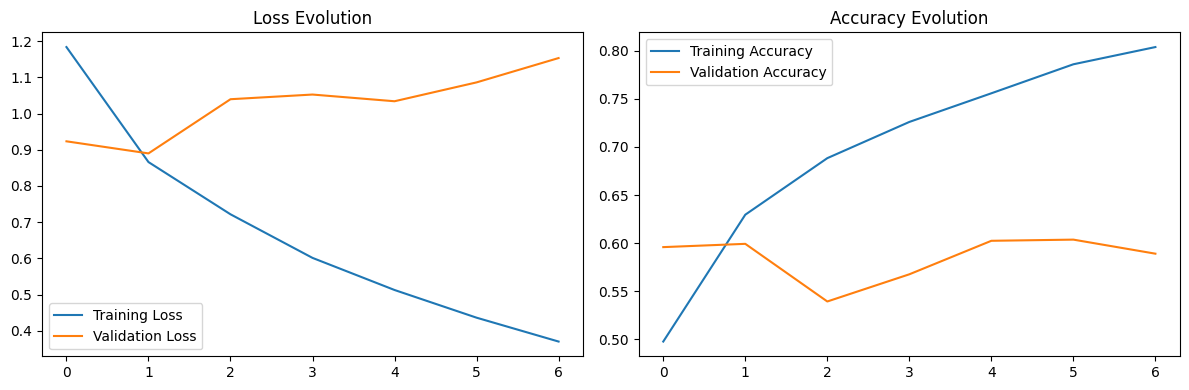

In [ ]:
# Plotting loss and accuracy curves using the best model
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.tight_layout()
plt.show()

### ***Observation:***

Results are good too. It seems like with class weight the model focus more on the recall while the other model without class weight was more focused on accuracy. the model is also il little less overfitting

In [ ]:
from keras.regularizers import l2

model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Bidirectional(LSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))),  # Bi-LSTM with L2 regularization
    Dropout(0.5),  # Increased dropout rate
    Dense(5, activation='softmax', kernel_regularizer=l2(0.01), activity_regularizer=l2(0.01))  # Regularized Dense layer
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 200, 64)           640000    
                                                                 
 bidirectional_6 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 5)                 645       
                                                                 
Total params: 706693 (2.70 MB)
Trainable params: 706693 (2.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
train_sequences, val_sequences, train_labels, val_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

history = model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=11, batch_size=64, callbacks=[checkpoint, early_stopping_cb, lr_cb])

Epoch 1/11
257/257 [==============================] - ETA: 0s - loss: 1.8898 - accuracy: 0.4593
Epoch 1: val_loss did not improve from 0.84617
257/257 [==============================] - 95s 350ms/step - loss: 1.8898 - accuracy: 0.4593 - val_loss: 1.1526 - val_accuracy: 0.5255 - lr: 0.0010
Epoch 2/11
257/257 [==============================] - ETA: 0s - loss: 1.0865 - accuracy: 0.5501
Epoch 2: val_loss did not improve from 0.84617
257/257 [==============================] - 86s 335ms/step - loss: 1.0865 - accuracy: 0.5501 - val_loss: 1.0551 - val_accuracy: 0.5528 - lr: 0.0010
Epoch 3/11
257/257 [==============================] - ETA: 0s - loss: 1.0122 - accuracy: 0.5855
Epoch 3: val_loss did not improve from 0.84617
257/257 [==============================] - 89s 346ms/step - loss: 1.0122 - accuracy: 0.5855 - val_loss: 1.0278 - val_accuracy: 0.5865 - lr: 0.0010
Epoch 4/11
257/257 [==============================] - ETA: 0s - loss: 0.9574 - accuracy: 0.6241
Epoch 4: val_loss did not improve 

In [ ]:
# model evaluation
val_loss, val_accuracy = model.evaluate(val_sequences, val_labels)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# get prédictions
predictions = model.predict(val_sequences)
predicted_labels = [np.argmax(prediction) for prediction in predictions]

# classification report
print(classification_report(val_labels, predicted_labels))

129/129 [==============================] - 10s 81ms/step - loss: 1.0467 - accuracy: 0.5975
Validation Loss: 1.0466907024383545
Validation Accuracy: 0.5974627733230591
129/129 [==============================] - 8s 59ms/step
              precision    recall  f1-score   support

           0       0.77      0.40      0.53       292
           1       0.39      0.44      0.42       333
           2       0.35      0.28      0.31       432
           3       0.51      0.49      0.50      1252
           4       0.71      0.81      0.76      1790

    accuracy                           0.60      4099
   macro avg       0.55      0.48      0.50      4099
weighted avg       0.59      0.60      0.59      4099



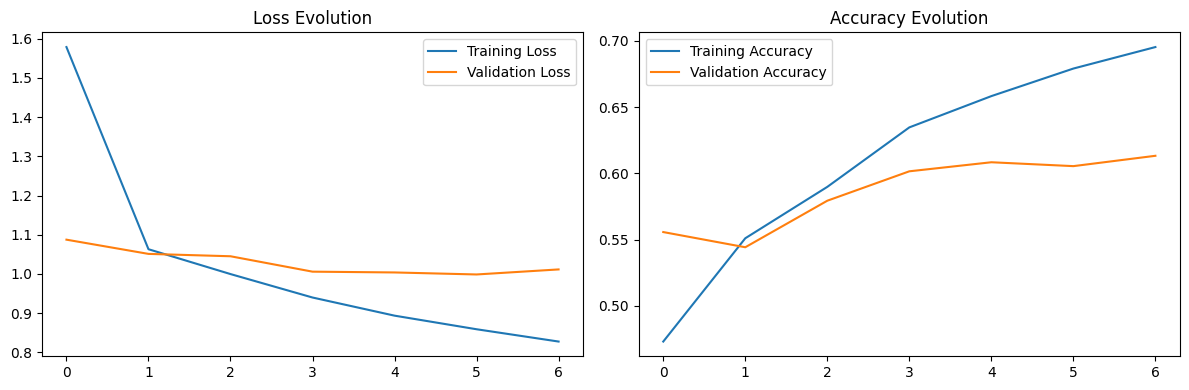

In [ ]:
# Plotting loss and accuracy curves using the best model
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.tight_layout()
plt.show()

### ***Observation:***

Result are not as good but we have a model that overfit less. the curves are close to each other so we can imagine that this model will be better to generalize

# Re mapping the dataset

In [45]:
dataset = pd.read_csv('/content/cleaned_tripadvisor_reviews.csv', index_col=0)
mapping = {1: 0, 2: 0, 3: 0, 4: 1, 5: 2}
dataset['sentiment'] = dataset['Rating'].map(mapping)
labels = dataset['sentiment'].values


In [63]:
model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Bidirectional(LSTM(64, kernel_regularizer=l2(0.01))),
    Dropout(0.4),
    Dense(5, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 100, 64)           640000    
                                                                 
 bidirectional_12 (Bidirect  (None, 128)               66048     
 ional)                                                          
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 5)                 645       
                                                                 
Total params: 706693 (2.70 MB)
Trainable params: 706693 (2.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [64]:
train_sequences, val_sequences, train_labels, val_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
checkpoint = ModelCheckpoint('model1.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
lr_cb = ReduceLROnPlateau(monitor="loss", patience=10)


history = model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=12, batch_size=32, callbacks=[checkpoint, early_stopping_cb, lr_cb])


Epoch 1/12
513/513 [==============================] - ETA: 0s - loss: 1.3989 - accuracy: 0.4849
Epoch 1: val_loss improved from inf to 0.93069, saving model to model1.h5
513/513 [==============================] - 40s 73ms/step - loss: 1.3989 - accuracy: 0.4849 - val_loss: 0.9307 - val_accuracy: 0.5843 - lr: 5.0000e-04
Epoch 2/12
  2/513 [..............................] - ETA: 35s - loss: 0.9311 - accuracy: 0.6094

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


513/513 [==============================] - ETA: 0s - loss: 0.8985 - accuracy: 0.6015
Epoch 2: val_loss improved from 0.93069 to 0.77192, saving model to model1.h5
513/513 [==============================] - 39s 76ms/step - loss: 0.8985 - accuracy: 0.6015 - val_loss: 0.7719 - val_accuracy: 0.6548 - lr: 5.0000e-04
Epoch 3/12
513/513 [==============================] - ETA: 0s - loss: 0.7182 - accuracy: 0.6905
Epoch 3: val_loss improved from 0.77192 to 0.72412, saving model to model1.h5
513/513 [==============================] - 38s 75ms/step - loss: 0.7182 - accuracy: 0.6905 - val_loss: 0.7241 - val_accuracy: 0.6782 - lr: 5.0000e-04
Epoch 4/12
513/513 [==============================] - ETA: 0s - loss: 0.6263 - accuracy: 0.7382
Epoch 4: val_loss improved from 0.72412 to 0.71094, saving model to model1.h5
513/513 [==============================] - 38s 75ms/step - loss: 0.6263 - accuracy: 0.7382 - val_loss: 0.7109 - val_accuracy: 0.6802 - lr: 5.0000e-04
Epoch 5/12
513/513 [===================

In [65]:
# model evaluation
val_loss, val_accuracy = model.evaluate(val_sequences, val_labels)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# get prédictions
predictions = model.predict(val_sequences)
predicted_labels = [np.argmax(prediction) for prediction in predictions]

# classification report
print(classification_report(val_labels, predicted_labels))

129/129 [==============================] - 2s 19ms/step - loss: 0.7109 - accuracy: 0.6802
Validation Loss: 0.7109366655349731
Validation Accuracy: 0.6801658868789673
129/129 [==============================] - 3s 16ms/step
              precision    recall  f1-score   support

           0       0.75      0.80      0.77      1057
           1       0.51      0.59      0.55      1252
           2       0.79      0.68      0.73      1790

    accuracy                           0.68      4099
   macro avg       0.68      0.69      0.68      4099
weighted avg       0.69      0.68      0.68      4099



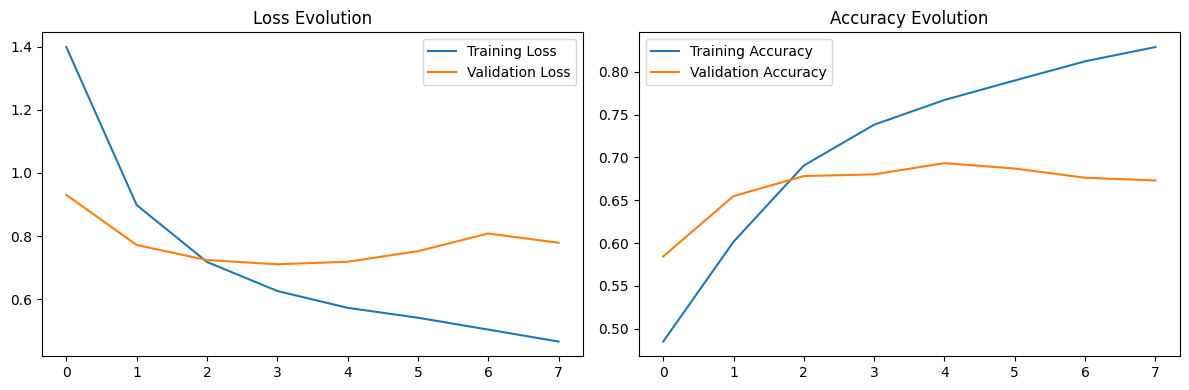

In [66]:
# Plotting loss and accuracy curves using the best model
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.tight_layout()
plt.show()